In [1]:
include("../src/cdem.jl")

Main.cdem_julia

In [2]:
Threads.nthreads()

8

In [3]:
using Plots
using JLD2, FileIO, CodecZlib
using .cdem_julia: mod_laser, mod_physicalconstants, mod_utils, mod_customtypes, mod_discrete,
mod_cdem, mod_eels, mod_electron, mod_material
using ..mod_customtypes:Discretization
using ..mod_electron:Electron

In [4]:
las = mod_laser.set_laser!()
mod_laser.set_laser!(;laser=las,
    pulse_energy_experiment = 1 * 1e-9,
    pulse_energy_gain_factor = 0.014,
    laser_spot_fwhm = 40e-6,
    theta_pol = 90*pi/180,
    laser_pulse_time_fwhm = 650e-15);

dis_sp = mod_discrete.discretization_setup(;x0 = 0.,
    y0 = -1e-6,
    d_xprime = 4e-2 * 3 * mod_utils.calculate_sigma(las.laser_spot_fwhm),
    d_yprime = 4e-2 * 1e-6,
    d_zprime = 4e-2 * 3 * mod_utils.calculate_sigma(las.laser_spot_fwhm),
    xprime_max = 3 * mod_utils.calculate_sigma(las.laser_spot_fwhm),
    yprime_max = 1e-6,
    zprime_max = 3 * mod_utils.calculate_sigma(las.laser_spot_fwhm),
    d_z = 2e-6,
    zmax = 1e-4,
    z_max = 30e-6,
    t0 = -0.5e-12,
    ddt = 10e-15,
    delay_max = 3e-12,
    fs = 2.4e15,
    l = 1.08e4)

mat = mod_material.IndiumArsenide()
elec = mod_electron.set_electron!()
mod_electron.set_electron!(;electron=elec,
    electron_total_energy = 0.94,
    electron_total_time_fs = 360.0,
    electron_time_coherent_fwhm_fs = 50.0,
    electron_theta = -7*pi/180,
    electron_velocity_c = 0.7)

numericalp = mod_customtypes.NumericalParameters(;tc_subsampling = 30,subsampling_factor = 60)

Main.cdem_julia.mod_customtypes.NumericalParameters(30, 60)

In [5]:
base="c:/Users/kaiza/OneDrive/Desktop/code/JuliaCheck/analysis_photodember/saved-matrices/interact_v_onepulse"

v_struct = load(base*".jld2");

t_c = dis_sp.t[dis_sp.t .> dis_sp.t0];
t_c_subsampled = t_c[1:numericalp.tc_subsampling:end];
w, e_w, t_w = mod_electron.energy_time_grid(elec,numericalp.subsampling_factor,dis_sp.energy, dis_sp.deltat);

interaction_v_pd = v_struct["photodember"]

alpha_pd_0 =  .07;
alpha_or_0 = 20 * 1.3 * 1.2;

interact_v_pd = circshift(interaction_v_pd, (18,0));

angle_array = sort(vcat([0:20:180;],[45, 135]))

12-element Vector{Int64}:
   0
  20
  40
  45
  60
  80
 100
 120
 135
 140
 160
 180

In [6]:
function loss_spectrum!(psi_sub_array::Array{Float64,3},
    psi_incoherent_array::Array{Float64,3},
    ind::Int64,
    interact_v::Array{Float64,2}, 
    discretization::Discretization,
    elec::Electron)
        
    f_t = mod_eels.calculate_ft(discretization, interact_v , elec);
    
    psi = mod_eels.calculate_psi_coherent(dis_sp, elec, f_t);
    psi_sub = mod_eels.psi_subsampled(numericalp.subsampling_factor,psi, e_w);
    @views @inbounds psi_sub_array[:,:,ind] .= psi_sub
    @views @inbounds psi_incoherent_array[:,:,ind] .= mod_eels.incoherent_convolution_fast(psi_sub, w, t_w, e_w);
end

function loss_spectrum_single!(interact_v::Array{Float64,2}, 
    discretization::Discretization,
    elec::Electron)
        
    f_t = mod_eels.calculate_ft(discretization, interact_v , elec);
    
    psi = mod_eels.calculate_psi_coherent(dis_sp, elec, f_t);
    psi_sub = mod_eels.psi_subsampled(numericalp.subsampling_factor,psi, e_w);
    
    psi_incoherent = mod_eels.incoherent_convolution_fast(psi_sub, w, t_w, e_w);

    return psi_sub, psi_incoherent
end

loss_spectrum_single! (generic function with 1 method)

In [84]:
alpha_pd_0 =  .03;
alpha_or_0 = 10 * 1.3 * 1.2;

# v_or = alpha_or_0 .* circshift(v_struct["angle_"*string(150)], (-15,0));
# @time psi_sub_130, psi_incoherent_130 = loss_spectrum_single!(v_or, dis_sp, elec);

# v_pd = alpha_pd_0 .* circshift(v_struct["photodember"], (18,0));
# @time psi_sub_pd0, psi_incoherent_pd0 = loss_spectrum_single!(v_pd, dis_sp, elec);

v_or = alpha_or_0 .* circshift(v_struct["angle_"*string(150)], (0,0));
@time psi_sub_130, psi_incoherent_130 = loss_spectrum_single!(v_or, dis_sp, elec);


  3.300158 seconds (39.93 k allocations: 4.381 GiB, 29.51% gc time)


In [97]:

shift_array = 16:22;

v_pd_array = zeros(size(v_or)...,length(shift_array))

for (ind, shift) in enumerate(shift_array)
    @time v_pd_array[:,:,ind] .= alpha_pd_0 .* circshift(v_struct["photodember"], (shift,0));
end


  0.005761 seconds (11 allocations: 8.323 MiB)
  0.004938 seconds (11 allocations: 8.323 MiB)
  0.004120 seconds (11 allocations: 8.323 MiB)
  0.003745 seconds (11 allocations: 8.323 MiB)


  0.004288 seconds (11 allocations: 8.323 MiB)
  0.006047 seconds (11 allocations: 8.323 MiB)
  0.005616 seconds (11 allocations: 8.323 MiB)


In [98]:
size(v_pd_array)

(101, 10801, 7)

In [99]:
psi_sub_comb_array = zeros(size(psi_sub_130)...,length(shift_array));
psi_incoherent_comb_array = zeros(size(psi_incoherent_130)...,length(shift_array));
psi_sub_pd_array = zeros(size(psi_sub_130)...,length(shift_array));
psi_incoherent_pd_array = zeros(size(psi_incoherent_130)...,length(shift_array));
;
for (ind, _) in enumerate(shift_array)
    @time psi_sub_comb, psi_incoherent_comb = loss_spectrum_single!(v_pd_array[:,:,ind].+v_or, dis_sp, elec);
    psi_sub_comb_array[:,:,ind] = psi_sub_comb;
    psi_incoherent_comb_array[:,:,ind] = psi_incoherent_comb;

    @time psi_sub_pd, psi_incoherent_pd = loss_spectrum_single!(v_pd_array[:,:,ind], dis_sp, elec);
    psi_sub_pd_array[:,:,ind] = psi_sub_pd;
    psi_incoherent_pd_array[:,:,ind] = psi_incoherent_pd;
end


  2.849903 seconds (39.94 k allocations: 4.397 GiB, 19.98% gc time)


  3.311486 seconds (39.97 k allocations: 4.389 GiB, 30.53% gc time)


  3.113084 seconds (39.98 k allocations: 4.397 GiB, 24.41% gc time)


  3.070361 seconds (39.98 k allocations: 4.389 GiB, 24.96% gc time)


  3.078951 seconds (39.99 k allocations: 4.397 GiB, 25.00% gc time)


  3.325466 seconds (39.98 k allocations: 4.389 GiB, 32.11% gc time)

  3.250763 seconds (40.03 k allocations: 4.397 GiB, 30.34% gc time)


  3.338876 seconds (39.98 k allocations: 4.389 GiB, 31.24% gc time)


  3.232658 seconds (39.98 k allocations: 4.397 GiB, 28.16% gc time)

  3.316129 seconds (40.03 k allocations: 4.389 GiB, 30.50% gc time)

  3.417082 seconds (40.03 k allocations: 4.397 GiB, 30.35% gc time)

  3.412003 seconds (40.03 k allocations: 4.389 GiB, 30.71% gc time)


  3.225683 seconds (39.98 k allocations: 4.397 GiB, 28.46% gc time)


  3.205424 seconds (39.98 k allocations: 4.389 GiB, 28.45% gc time)


In [126]:
plot_agg = [];
gr(;size=(500,1000))
p_rect = heatmap(e_w, t_w .- 0.2, psi_sub_130, c =:jet, 
aspect_ratio = 9/2.5,
xlims=[-4.5,4.5],
ylims=[-1,1.5],
colorbar=false,
xaxis=true,
yaxis=true,
right_margin = 0Plots.mm,
bottom_margin = -10Plots.mm);
yflip!(true);

for (ind, _) in enumerate(shift_array)
    print(ind)
    p_pd = heatmap(e_w, t_w .- 0.2, psi_sub_pd_array[:,:,ind], c =:jet, 
    aspect_ratio = 9/2.5,
    xlims=[-4.5,4.5],
    ylims=[-1,1.5],
    colorbar=false,
    xaxis=(ind==length(shift_array) ? true : false),
    yaxis=false,
    right_margin = 0Plots.mm,
    bottom_margin = -10Plots.mm);
    yflip!(true);
    

    p = heatmap(e_w, t_w .- 0.2, psi_sub_comb_array[:,:,ind], c =:jet, 
    aspect_ratio = 9/2.5,
    xlims=[-4.5,4.5],
    ylims=[-1,1.5],
    colorbar=false,
    xaxis=(ind==length(shift_array) ? true : false),
    yaxis=false,
    right_margin = 0Plots.mm,
    bottom_margin = -10Plots.mm);
    yflip!(true);
    

    push!(plot_agg,p_rect);
    push!(plot_agg,p_pd);
    push!(plot_agg,p);

end


1

2

3

4

5

6

7

UndefVarError: UndefVarError: plt not defined

In [127]:

gui(plot(plot_agg...,layout=(7,3)))
# default(show = true)

In [101]:
size(plot_agg)

(21,)

In [107]:
length(shift_array)

7

In [103]:
# alpha_pd_0 =  .01;
# alpha_or_0 = 10 * 1.3 * 1.2;

v_or = alpha_or_0 .* circshift(v_struct["angle_"*string(150)], (0,0));
@time psi_sub_130, psi_incoherent_130 = loss_spectrum_single!(v_or, dis_sp, elec);

v_pd = alpha_pd_0 .* circshift(v_struct["photodember"], (18,0));
@time psi_sub_pd0, psi_incoherent_pd0 = loss_spectrum_single!(v_pd, dis_sp, elec);


# v_or = alpha_or_0 .* circshift(v_struct["angle_"*string(150)], (0,0));
# @time psi_sub_130, psi_incoherent_130 = loss_spectrum_single!(v_or, dis_sp, elec);

# v_pd = alpha_pd_0 .* circshift(v_struct["photodember"], (0,0));
# @time psi_sub_pd0, psi_incoherent_pd0 = loss_spectrum_single!(v_pd, dis_sp, elec);


  3.574282 seconds (39.94 k allocations: 4.381 GiB, 36.98% gc time)

  3.158193 seconds (40.02 k allocations: 4.381 GiB, 26.45% gc time)


([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0013862813944863557 0.0013869535502122191 … 0.0013873125567026474 0.001386400883199853; 0.0013848716219344586 0.0013853904138210929 … 0.001386207066802041 0.0013851434790654365; … ; 0.0013850782737105621 0.0013860573381553492 … 0.0013854934119365474 0.0013848904815659294; 0.0013863509642529253 0.0013871781277185846 … 0.001387072191401055 0.001386315655162307])

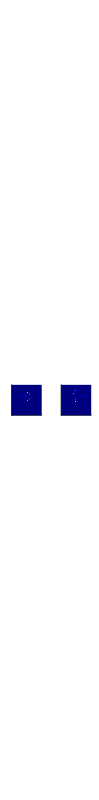

In [104]:
plot_agg = [];

p = heatmap(e_w, t_w .- 0.2, psi_sub_130, c =:jet, 
aspect_ratio = 9/2.5,
xlims=[-4.5,4.5],
ylims=[-1,1.5],
colorbar=false,
xaxis=nothing,
yaxis=nothing,
right_margin = -0Plots.mm);
yflip!(true);
push!(plot_agg,p)

p = heatmap(e_w, t_w .- 0.2, psi_sub_pd0, c =:jet, 
aspect_ratio = 9/2.5,
xlims=[-4.5,4.5],
ylims=[-1,1.5],
colorbar=false,
xaxis=nothing,
yaxis=nothing,
right_margin = -0Plots.mm);
yflip!(true);
push!(plot_agg,p)

plot(plot_agg...,layout=(1,2))